In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score
import _pickle as pk
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
random.seed(1)

import copy, warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
config = {
    'num_train': 20000,
    'num_valid': 5000,
    'pred_maxlen': 10,
    
    'lr': 0.001,
    'mt': 0.99,
    'emb_dim': 64,
    'lstm_size': 128,
    'attn_size': 100,
    'dropout': 0.5,
    'batch': 32,
    'epoch': 50,
    
    'testfile': "test.txt",
    'lossfile': 'model_noattn.loss',
    'checkpoint': "model_noattn.pt"
}

In [3]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

train_inp, train_out = sorting_letters_dataset(config['num_train'])
valid_inp, valid_out = sorting_letters_dataset(config['num_valid'])

In [4]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 

src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

def map_elems(elems, mapper):
    return [mapper[elem] for elem in elems]

def map_many_elems(many_elems, mapper):
    return [map_elems(elems, mapper) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi)
train_y = map_many_elems(train_out, tgt_vocab.stoi)
print("Length of the training dataset: {}".format(len(train_x)))

valid_x = map_many_elems(valid_inp, src_vocab.stoi)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi)
print("Length of the validation dataset: {}".format(len(valid_x)))

PAD_IX   = tgt_vocab.stoi['<pad>']
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

Length of the training dataset: 20000
Length of the validation dataset: 5000


In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, enc_inputs):
        batch_inputs = copy.deepcopy(enc_inputs)
        device = next(self.parameters()).device
        
        x_tensor = [torch.tensor(sample).to(device) for sample in batch_inputs]
        x_pad = pad_sequence(x_tensor, batch_first=True, padding_value=0) # (batch, seqlen) 
        x_emb = self.emb(x_pad) # (batch, seqlen, emb_dim) 
        x_emb = self.drop(x_emb)
        
        x_len = [len(sample) for sample in batch_inputs]
        x_pack = pack_padded_sequence(x_emb, x_len, batch_first=True, enforce_sorted=False)
        outs_pack, (h_n, c_n) = self.lstm(x_pack)
        outs, _ = pad_packed_sequence(outs_pack, batch_first=True)
            
        if self.z_index == 1:
            return h_n[0], c_n[0] # (seqlen, batch, lstm_dim)
        else:
            return outs # (batch, seqlen, lstm_dim)

encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_dim'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
print(encoder)

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)


In [6]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.clf = nn.Linear(lstm_size, vocab_size)
        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none", ignore_index=tgt_vocab.stoi['<pad>'])
    
    def pad_targets(self, targets):
        last_token = tgt_vocab.stoi['<stop>']
        pad_token = tgt_vocab.stoi['<pad>']
        maxlen = max([len(target) for target in targets])
        for i in range(len(targets)): 
            targets[i].append(last_token) #added last token
            targets[i].extend([pad_token] * (maxlen + 1 - len(targets[i]))) #added pad token
        return targets, maxlen
    
    def forward(self, state, dec_targets, curr_token, last_token):
        batch_targets = copy.deepcopy(dec_targets)
        device = next(self.parameters()).device
        batch_size = state[0].shape[0]

        batch_targets, maxlen = self.pad_targets(batch_targets)
        
        batch_loss = 0.0
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            emb = self.drop(emb) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            q_i, _ = state 
            q_i = self.drop(q_i) # (batch, lstm_dim)
            
            scores = self.clf(q_i) # (batch, tgt_vocab)
            
            next_tokens = [targets[i] for targets in batch_targets]
            targets = torch.tensor(next_tokens).to(device) # (batch)
            batch_loss += self.objective(scores, targets) # (batch)
            
            curr_tokens = next_tokens
        
        maskcount = [np.count_nonzero(targets) for targets in batch_targets]
        maskcount = torch.tensor(maskcount, dtype=torch.float32).to(device)
        batch_loss = (batch_loss/maskcount).sum()
        
        return batch_loss

    def predict(self, state, curr_token, last_token, maxlen):
        device = next(self.parameters()).device
        batch_size = state[0].shape[0]
        
        batch_preds = []
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            h_i, _ = state 
            
            scores = self.clf(h_i) # (batch, tgt_vocab)
            
            pred_tokens = torch.argmax(torch.softmax(scores, dim=1), dim=1) # (batch)
            curr_tokens = pred_tokens
            batch_preds.append(pred_tokens.tolist())

        batch_preds = np.array(batch_preds).T.tolist()
        for ix, _ in enumerate(batch_preds):
            if last_token in batch_preds[ix]:
                last_token_ix = batch_preds[ix].index(last_token)
                batch_preds[ix] = batch_preds[ix][:last_token_ix]
        return batch_preds

    def evaluate(self, state, dec_targets, curr_token, last_token):
        batch_targets = copy.deepcopy(dec_targets)
        device = next(self.parameters()).device
        batch_size = state[0].shape[0]
        
        batch_targets, maxlen = self.pad_targets(batch_targets)
        
        batch_preds, batch_loss = [], 0.0
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            h_i, _ = state
            
            scores = self.clf(h_i) # (batch, tgt_vocab)
            
            next_tokens = [targets[i] for targets in batch_targets]
            targets = torch.tensor(next_tokens).to(device) # (batch)
            batch_loss += self.objective(scores, targets) # (batch)
            
            pred_tokens = torch.argmax(torch.softmax(scores, dim=1), dim=1) # (batch)
            curr_tokens = pred_tokens
            batch_preds.append(pred_tokens.tolist())
        
        maskcount = [np.count_nonzero(targets) for targets in batch_targets]
        maskcount = torch.tensor(maskcount, dtype=torch.float32).to(device)
        batch_loss = (batch_loss/maskcount).sum()
        
        batch_preds = np.array(batch_preds).T.tolist()
        for ix, _ in enumerate(batch_preds):
            if last_token in batch_preds[ix]:
                last_token_ix = batch_preds[ix].index(last_token)
                batch_preds[ix] = batch_preds[ix][:last_token_ix]
        
        return batch_preds, batch_loss

decoder = Decoder(vocab_size=len(tgt_vocab), 
                  emb_dim=config['emb_dim'], 
                  lstm_size=config['lstm_size'])
print(decoder)

Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)


In [7]:
def map_prediction(sample_preds):
    sample_preds = [[tgt_vocab.itos[ix] for ix in each_preds] for each_preds in sample_preds]
    sample_preds = [''.join(each_preds) for each_preds in sample_preds]
    return sample_preds

def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

def evaluate(encoder, decoder, sample_x, sample_y, batch_size):
    encoder.eval()
    decoder.eval()
    
    sample_loss = 0.0
    batch_x, batch_y = [], []
    predictions, actuals = [], []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            batch_y.append(sample_y[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds, batch_loss = decoder.evaluate(encoder(batch_x), batch_y, START_IX, STOP_IX)
                
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_y = map_prediction(batch_y)
                actuals.extend(batch_y)
                
                sample_loss += batch_loss.item()
                batch_x, batch_y = [], []
    
    sample_loss = sample_loss / len(sample_x) * 1.0
    
    accuracy = accuracy_score(actuals, predictions)
    return predictions, sample_loss, accuracy

def train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size):
    encoder.train()
    decoder.train()

    train_loss = 0.0
    train_x, train_y = shuffle(train_x, train_y)
    batch_x, batch_y = [], []

    for i in range(len(train_x)):
        batch_x.append(train_x[i])
        batch_y.append(train_y[i])

        if len(batch_x) == batch_size or i == len(train_x) - 1:
            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()
        
            batch_loss = decoder(encoder(batch_x), batch_y, START_IX, STOP_IX)

            batch_loss.backward()
            enc_optim.step()
            dec_optim.step()

            train_loss += batch_loss.item()
            batch_x, batch_y = [], []

    train_loss = train_loss / len(train_x) * 1.0
    
    return encoder, decoder, train_x, train_y, train_loss

In [8]:
def getCurrentTime():
    return str(datetime.datetime.now())

def track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss):
    if best_acc >= valid_acc:
        return best_acc, ''
    state = {
        'encoder': encoder.state_dict(), 
        'decoder': decoder.state_dict(),
        'acc': valid_acc,
        'loss': valid_loss,
        'epoch': epoch
    }
    torch.save(state, config['checkpoint'])
    return valid_acc, ' * '

def training_loop(encoder, decoder, train_x, train_y, epochs, batch_size, print_every=1):
    print("\nTraining with encoder and decoder...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("\nAttaching to device: {}".format(device))
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=config['lr'], momentum=config['mt'])
    dec_optim = optim.SGD(decoder.parameters(), lr=config['lr'], momentum=config['mt'])
    
    best_acc = -1.0
    keep_loss = [[], []] # [[train],[valid]]
    
    for epoch in range(1, epochs+1):
        encoder, decoder, train_x, train_y, train_loss = train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size)
        _, valid_loss, valid_acc = evaluate(encoder, decoder, valid_x, valid_y, batch_size)
        best_acc, epoch_track = track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss)

        
        keep_loss[0].append(train_loss)
        keep_loss[1].append(valid_loss)
        
        epoch_msg = '\n[{}] Epoch {:02d}: [TRAIN] Loss: {:.6f}'.format(getCurrentTime(), epoch, train_loss)
        epoch_msg += ' [VAL] Loss: {:.6f}, Acc: {:.6f}'.format(valid_loss, valid_acc)
        print(epoch_msg + epoch_track)
    
    with open(config['lossfile'], 'wb') as lossfile:
        pk.dump(keep_loss, lossfile)
    
    print("\nTraining completed...")
    return True

In [9]:
if not os.path.exists(config['checkpoint']):
    training_loop(encoder, decoder, train_x, train_y, config['epoch'], config['batch'])


Training with encoder and decoder...

Attaching to device: cuda

[2020-04-11 16:49:00.756264] Epoch 01: [TRAIN] Loss: 1.861466 [VAL] Loss: 1.316512, Acc: 0.196200 * 

[2020-04-11 16:49:09.398111] Epoch 02: [TRAIN] Loss: 0.761363 [VAL] Loss: 0.411303, Acc: 0.756800 * 

[2020-04-11 16:49:17.972774] Epoch 03: [TRAIN] Loss: 0.364769 [VAL] Loss: 0.145832, Acc: 0.934000 * 

[2020-04-11 16:49:26.607936] Epoch 04: [TRAIN] Loss: 0.211276 [VAL] Loss: 0.084716, Acc: 0.966200 * 

[2020-04-11 16:49:35.170264] Epoch 05: [TRAIN] Loss: 0.136912 [VAL] Loss: 0.054880, Acc: 0.975800 * 

[2020-04-11 16:49:43.739811] Epoch 06: [TRAIN] Loss: 0.101041 [VAL] Loss: 0.035897, Acc: 0.990600 * 

[2020-04-11 16:49:52.379275] Epoch 07: [TRAIN] Loss: 0.080776 [VAL] Loss: 0.032049, Acc: 0.991400 * 

[2020-04-11 16:50:00.950659] Epoch 08: [TRAIN] Loss: 0.068615 [VAL] Loss: 0.026040, Acc: 0.992600 * 

[2020-04-11 16:50:09.596581] Epoch 09: [TRAIN] Loss: 0.056566 [VAL] Loss: 0.010680, Acc: 0.997400 * 

[2020-04-11 16:5

In [10]:
def load_best_model():
    encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_dim'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
    decoder = Decoder(vocab_size=len(tgt_vocab),
                      emb_dim=config['emb_dim'], 
                      lstm_size=config['lstm_size'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(config['checkpoint'], map_location=device)
    encoder.load_state_dict(state['encoder'])
    decoder.load_state_dict(state['decoder'])
    state = {'acc': state['acc'], 'loss': state['loss'], 'epoch': state['epoch']}
    return encoder, decoder, state

keep_loss = [[], []] # [[train],[valid]]
with open(config['lossfile'], 'rb') as lossfile:
    keep_loss = pk.load(lossfile)
encoder, decoder, state = load_best_model()
print('Retrieving best model from epoch {} with [DEV] loss {:.6f} and accuracy {:.6f}.'.format(state['epoch'], state['loss'], state['acc'])) 

Retrieving best model from epoch 26 with [DEV] loss 0.001011 and accuracy 0.999800.


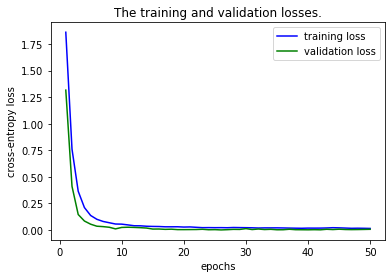

In [11]:
epochs = [i for i in range(1, len(keep_loss[0])+1)]
plt.plot(epochs, keep_loss[0], 'b', label="training loss")
plt.plot(epochs, keep_loss[1], 'g', label="validation loss")
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('cross-entropy loss')
plt.title('The training and validation losses.')
plt.show()

In [12]:
test_data = pd.read_csv(config['testfile'], delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]  

test_x = map_many_elems(test_inp, src_vocab.stoi)
test_y = map_many_elems(test_out, tgt_vocab.stoi)

print("Length of the test dataset: {}".format(len(test_x)))

Length of the test dataset: 5000


In [13]:
def predict(encoder, decoder, sample_x, batch_size, pred_size):
    encoder.eval()
    decoder.eval()
    
    batch_x = []
    predictions = []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds = decoder.predict(encoder(batch_x), START_IX, STOP_IX, pred_size)
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_x = []
            
    return predictions

def getAccuracyScore(encoder, decoder, sample_x, sample_out, batch_size, pred_size):
    predictions = predict(encoder, decoder, sample_x, batch_size, pred_size)
    groundtruth = [''.join(str_y) for str_y in sample_out]
    acc = accuracy_score(groundtruth, predictions)
    return acc

config['pred_maxlen'] = 10
test_acc = getAccuracyScore(encoder, decoder, test_x, test_out, config['batch'], config['pred_maxlen']) * 100
print('Accuracy on the test set (max prediction size = {}) = {:.2f}%'.format(config['pred_maxlen'], test_acc))

config['pred_maxlen'] = 20
test_acc = getAccuracyScore(encoder, decoder, test_x, test_out, config['batch'], config['pred_maxlen']) * 100
print('Accuracy on the test set (max prediction size = {}) = {:.2f}%'.format(config['pred_maxlen'], test_acc))

Accuracy on the test set (max prediction size = 10) = 97.80%
Accuracy on the test set (max prediction size = 20) = 99.70%
